# Last Notebook

## NAME : Fulin ZHANG

In this notebook, you will have to predict whether a candidate was hired or not (i.e., predict the column `embauche`).
The dataset is composed of 11 columns (features):
- date – application date 
- age - age of the candidate
- diplome – Highest diploma obtained (bac, licence, master, doctorat)
- specialite – speciality of the diploma (geology, detective, archeology, . . . )
- salaire – salaire demanded by the candidate
- dispo – oui : immediate avaialability, non : not available immediately
- sexe – female (F) or male (M)
- exp – nbr of years of experience
- cheveux – color of hair (châtain, brun, blond, roux)
- note – grade (over 100) obtained on the exercise
- embauche – 1: the candidate got hired, 0 the candidate did not get hired.

To complete this test, you will have to:
1. Split the data into train (70%), validation(10%), and test(20%) sets. 
2. Explore the data: look at your data, their types, check for missing values, incorrect values, duplicates, do some visualizations, set a list of changes you need to apply on these columns (one-hot encode some columns, bin others, eliminate others, etc.), check for balance or imbalance.
3. Apply the feature engineering you have identified in the previous step (the one-hot encoding, etc.)
4. Identify the metric to be optimized here (is it accuracy, precision, recall, f1-score, etc.)
5. Try several Machine Learning Models and do hyperparameter tuning using the validation set to find the best performing model.
6. Test your best model (or ensemble of models) on the test set, explain the results you got, and recommend on next steps (modifications that might bring better results).

Bonus: Deal with imbalance if any.


In [46]:
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, f_oneway

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler

import warnings

warnings.filterwarnings("ignore")


import jupyter_black

jupyter_black.load()

In [2]:
# Define the data path
data_path = os.path.join(os.getcwd(), "data", "data.csv")

# Import the data
data = pd.read_csv(data_path, low_memory=False)

# Take a look for the data
display(data.head())

,Unnamed: 0,index,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,0,0,2012-06-02,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,1,1,2011-04-21,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,2,2,2012-09-07,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
3,3,3,2011-07-01,brun,NaN,12.0,32442.0,M,licence,geologie,45.09,non,0
4,4,4,2012-08-07,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0


In [3]:
candidate_data = data.copy()

In [4]:
# Delete the useless column
candidate_data.drop(columns=["Unnamed: 0", "index", "date"], inplace=True)

In [5]:
# Take a look on the distribution
candidate_data.describe(include="all")

,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
count,19897,19909.000000,19904.000000,19905.000000,19900,19890,19907,19886.000000,19894,20000.000000
unique,4,NaN,NaN,NaN,2,4,4,NaN,2,NaN
top,chatain,NaN,NaN,NaN,M,master,geologie,NaN,non,NaN
freq,6022,NaN,NaN,NaN,11889,7513,10028,NaN,11848,NaN
mean,NaN,35.004521,9.500352,34974.343934,NaN,NaN,NaN,75.168762,NaN,0.114600
std,NaN,9.609169,3.012109,5003.099616,NaN,NaN,NaN,17.095926,NaN,0.318547
min,NaN,-3.000000,-2.000000,14128.000000,NaN,NaN,NaN,8.680000,NaN,0.000000
25%,NaN,29.000000,7.000000,31596.000000,NaN,NaN,NaN,63.720000,NaN,0.000000
50%,NaN,35.000000,9.000000,34979.000000,NaN,NaN,NaN,75.080000,NaN,0.000000
75%,NaN,41.000000,12.000000,38358.000000,NaN,NaN,NaN,86.617500,NaN,0.000000


There are some negative values in age and exp
Also some note > 100

In [6]:
candidate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   cheveux     19897 non-null  object 
 1   age         19909 non-null  float64
 2   exp         19904 non-null  float64
 3   salaire     19905 non-null  float64
 4   sexe        19900 non-null  object 
 5   diplome     19890 non-null  object 
 6   specialite  19907 non-null  object 
 7   note        19886 non-null  float64
 8   dispo       19894 non-null  object 
 9   embauche    20000 non-null  int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 1.5+ MB


In [7]:
categorical_features = candidate_data.select_dtypes(include="object").columns
numerical_features = candidate_data.select_dtypes(include="float64").columns

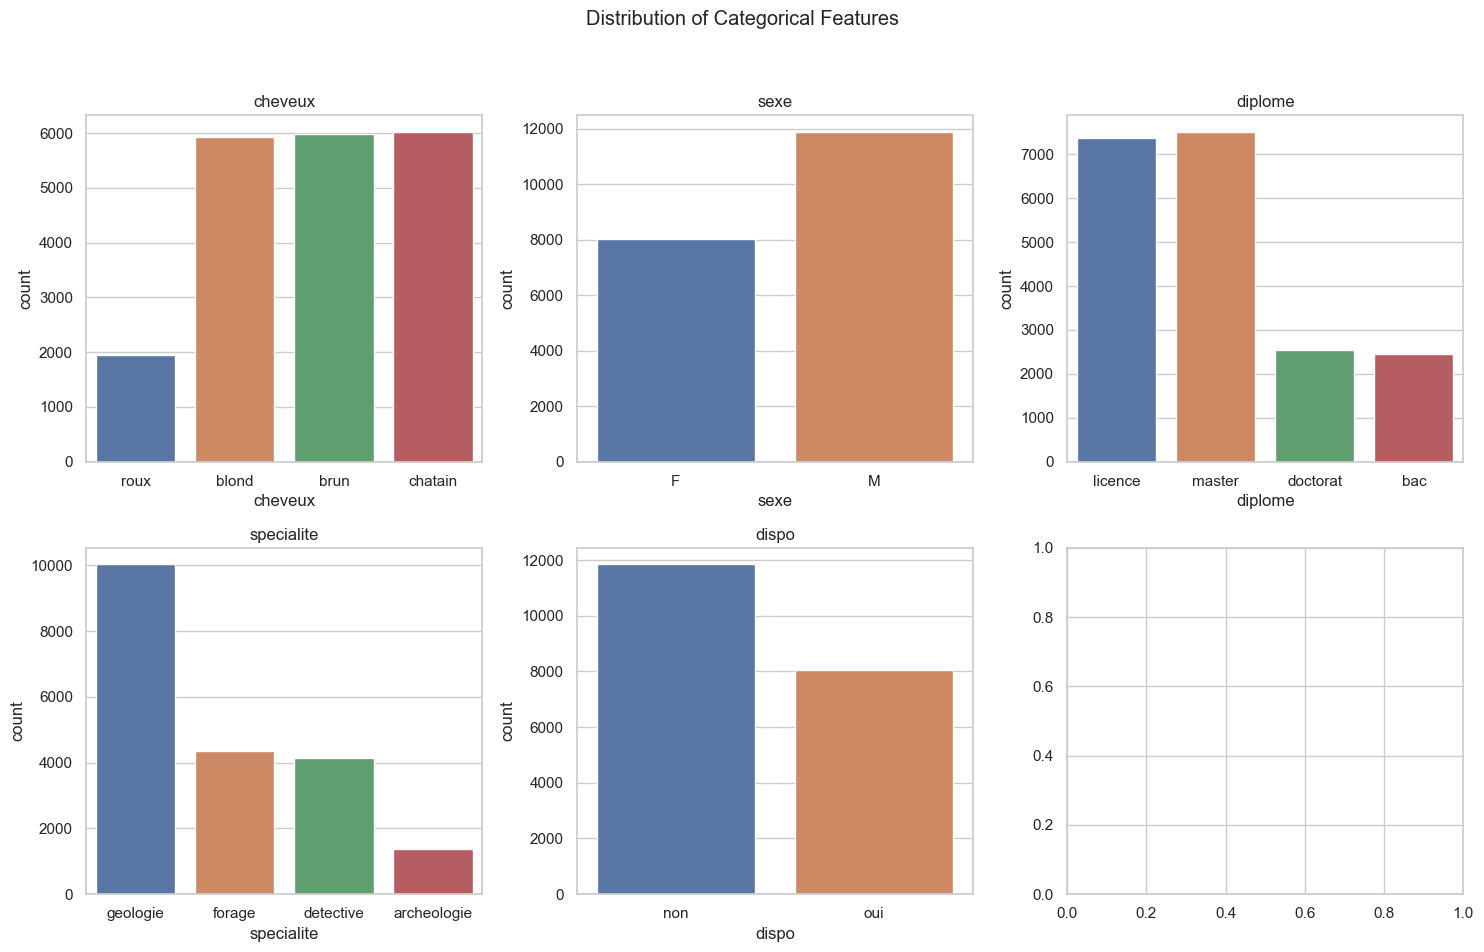

In [8]:
# Set the environment of the visualization
sns.set(style="whitegrid")

# Check the distribution of categorical features
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle("Distribution of Categorical Features")
for i, col in enumerate(categorical_features):
    ax = axes[i // 3, i % 3]
    sns.countplot(x=candidate_data[col], ax=ax)
    ax.set_title(col)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

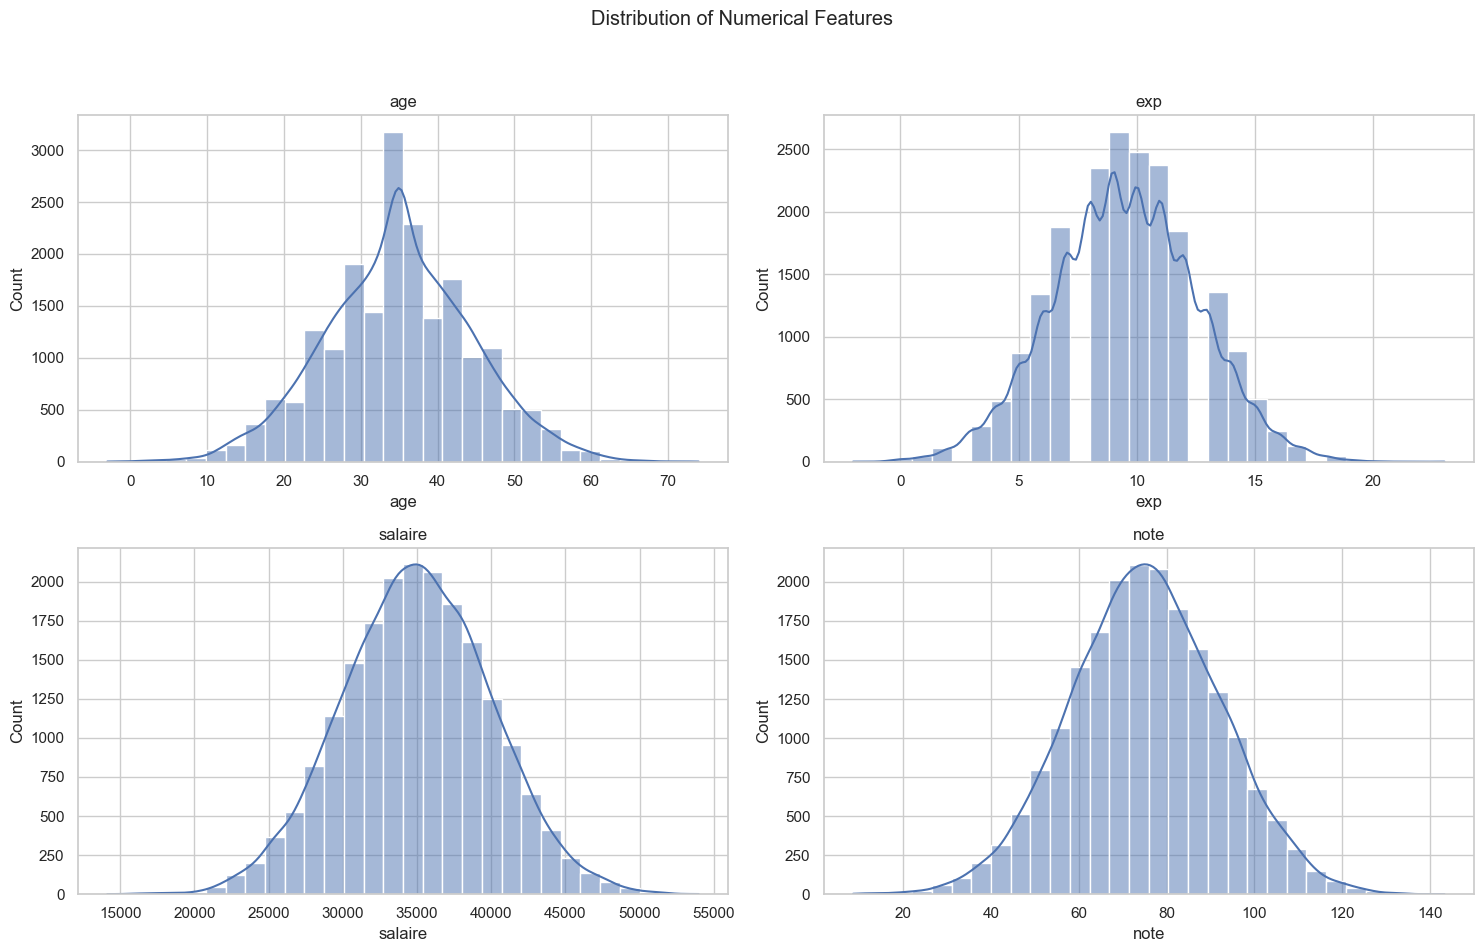

In [9]:
# Check the distribution of numerical features
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("Distribution of Numerical Features")
for i, col in enumerate(numerical_features):
    ax = axes[i // 2, i % 2]
    sns.histplot(candidate_data[col], bins=30, kde=True, ax=ax)
    ax.set_title(col)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

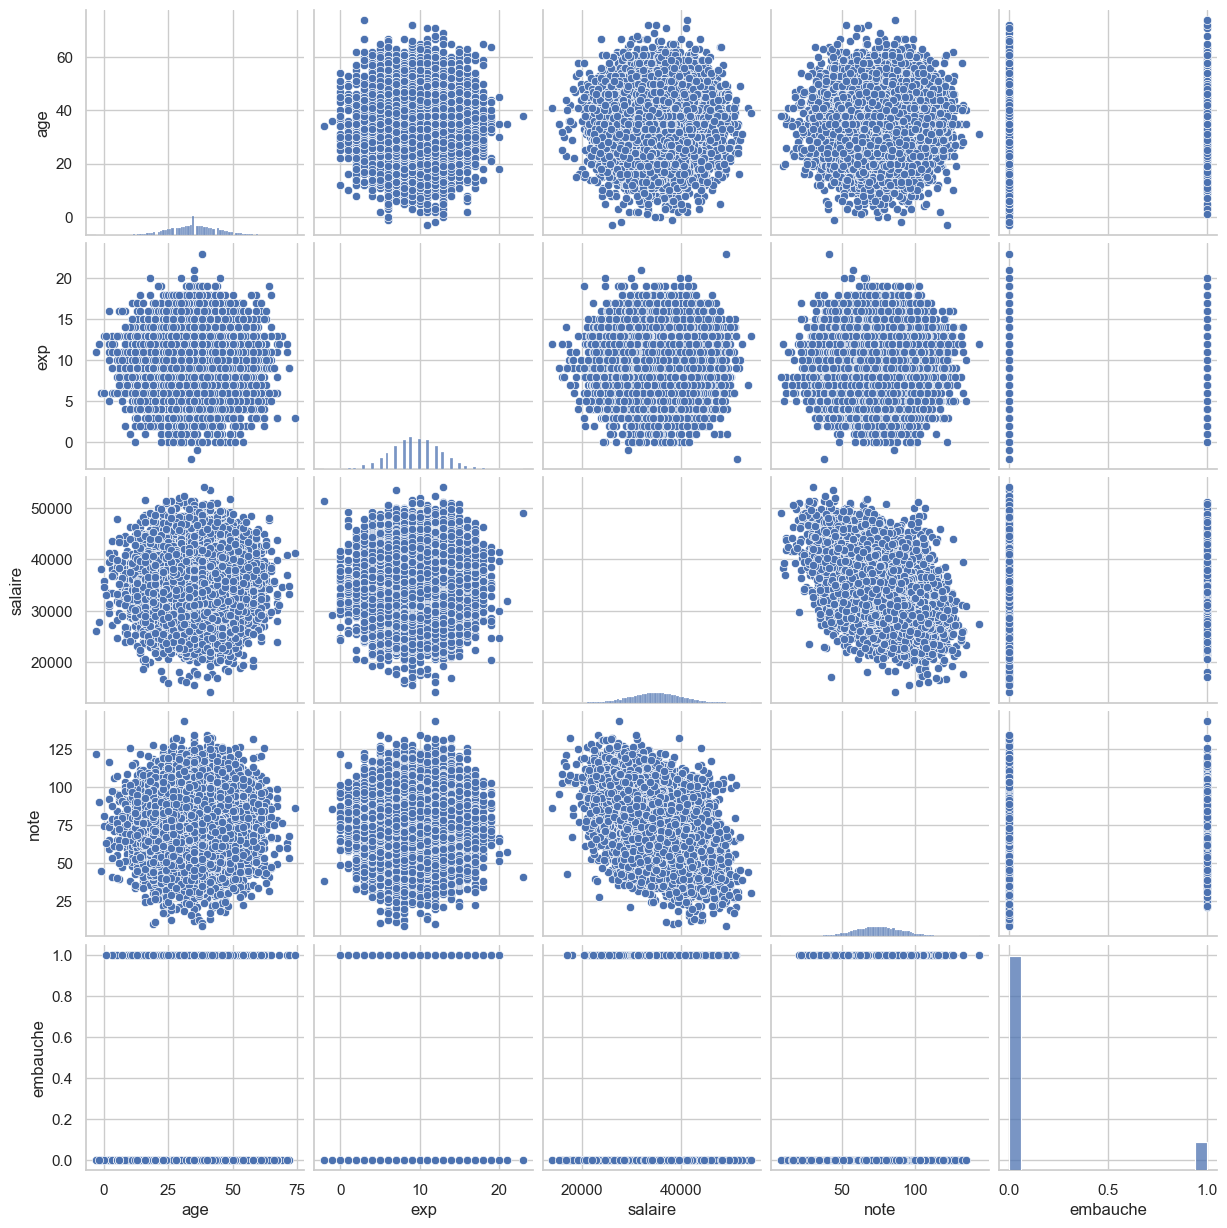

In [10]:
sns.pairplot(candidate_data)

It's very strange that note and salary expectations have a negative linear relationship. That is to say that by and large those who do lower note expect higher salaries.

Non embauche 88.54 % of the train-set
Embauche 11.46 % of the train-set


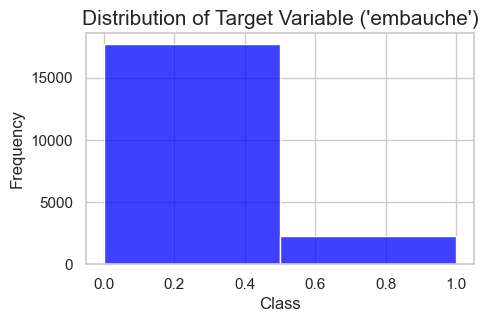

In [11]:
# The classes are heavily skewed we need to solve this issue later.

print(
    "Non embauche",
    round(
        candidate_data["embauche"].value_counts()[0]
        / len(candidate_data["embauche"])
        * 100,
        2,
    ),
    "% of the train-set",
)
print(
    "Embauche",
    round(
        candidate_data["embauche"].value_counts()[1]
        / len(candidate_data["embauche"])
        * 100,
        2,
    ),
    "% of the train-set",
)

plt.figure(figsize=(5, 3))
sns.histplot(candidate_data["embauche"], kde=False, color="blue", binwidth=0.5)
plt.title("Distribution of Target Variable ('embauche')", fontsize=15)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

The distribution of target values is extremely unbalanced.

In [12]:
# Take a look for the missing values
candidate_data.isnull().sum()

cheveux       103
age            91
exp            96
salaire        95
sexe          100
diplome       110
specialite     93
note          114
dispo         106
embauche        0
dtype: int64

In [13]:
# Generate the ratio of missing in embauched side

(
    round(
        candidate_data[candidate_data["embauche"] == 1].isnull().sum()
        / len(candidate_data[candidate_data["embauche"] == 1])
        * 100,
        2,
    ).astype("string")
    + "%"
)

cheveux       0.35%
age           0.44%
exp           0.35%
salaire       0.31%
sexe          0.52%
diplome       0.74%
specialite    0.31%
note           0.7%
dispo         0.57%
embauche       0.0%
dtype: string

Not too much missing in embauche = 1, so I just remove them

In [14]:
candidate_data.dropna(inplace=True)

In [15]:
candidate_data.duplicated().value_counts()

False    19109
dtype: int64

No duplicates

In [16]:
candidate_data = candidate_data.loc[
    (candidate_data["age"] > 0)
    & (candidate_data["exp"] > 0)
    & (candidate_data["note"] < 100)
    # & (candidate_data["age"] > (candidate_data["exp"] + 18)) # It's wired somebody have experience since 4 years old.
]

In [17]:
# creat two columns
candidate_data["experience ratio"] = round(
    candidate_data["exp"] / candidate_data["age"], 2
)
candidate_data["note vs salary"] = round(
    candidate_data["salaire"] / candidate_data["note"], 2
)

/var/folders/cr/dlw4zhlj7ld9t1grnb2q9hvw0000gn/T/ipykernel_65067/4257298420.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidate_data["experience ratio"] = round(
/var/folders/cr/dlw4zhlj7ld9t1grnb2q9hvw0000gn/T/ipykernel_65067/4257298420.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidate_data["note vs salary"] = round(


Still Wired about the guys 20+ year-old but have 15+ years experience. But I don't know the background.

In [18]:
def chi_squared_test(data, categorical_variable, target_variable):
    """
    Performs a Chi-squared test to evaluate the association between a categorical variable and a target variable.

    Parameters:
    data (DataFrame): The dataset containing the variables.
    categorical_variable (str): The name of the categorical variable.
    target_variable (str): The name of the target variable.

    Returns:
    tuple: Chi-squared statistic, P-value, Degrees of freedom, Expected frequencies
    """
    # Creating a contingency table
    contingency_table = pd.crosstab(data[categorical_variable], data[target_variable])

    # Performing the Chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    return chi2, p, dof, expected


def chi_squared_test_all_categorical(data, categorical_variables, target_variable):
    """
    Performs Chi-squared tests for all categorical variables in the dataset against the target variable.

    Parameters:
    data (DataFrame): The dataset containing the variables.
    categorical_variables (list): List of names of the categorical variables.
    target_variable (str): The name of the target variable.

    Returns:
    DataFrame: Results of the tests, including variable names, chi-squared statistics, P-values, and significance.
    """
    results = []
    for var in categorical_variables:
        if var != target_variable:
            chi2, p, _, _ = chi_squared_test(data, var, target_variable)
            results.append(
                {
                    "Variable": var,
                    "Chi-Squared": chi2,
                    "P-Value": p,
                    "Significant": p < 0.05,
                }
            )

    return pd.DataFrame(results)


# Identifying categorical variables
categorical_vars = [
    col for col in candidate_data.columns if candidate_data[col].dtype == "object"
]

# Running the chi-squared test for all categorical variables
chi_squared_results = chi_squared_test_all_categorical(
    candidate_data, categorical_vars, "embauche"
)
chi_squared_results.sort_values(by="P-Value")

,Variable,Chi-Squared,P-Value,Significant
3,specialite,144.626850,3.799404e-31,True
2,diplome,49.698192,9.263479e-11,True
0,cheveux,42.221270,3.600948e-09,True
4,dispo,1.375932,2.407953e-01,False
1,sexe,0.181867,6.697740e-01,False


In [19]:
from scipy.stats import f_oneway


def anova_test(data, quantitative_variable, categorical_target):
    """
    Performs an ANOVA test to evaluate the relationship between a quantitative variable and a categorical target variable.

    Parameters:
    data (DataFrame): The dataset containing the variables.
    quantitative_variable (str): The name of the quantitative variable.
    categorical_target (str): The name of the categorical target variable.

    Returns:
    F-statistic, P-value
    """
    # Splitting the data into groups based on the categorical target variable
    groups = data.groupby(categorical_target)[quantitative_variable]

    # Preparing the samples for ANOVA
    samples = [group.dropna() for name, group in groups]

    # Performing the ANOVA test
    f_statistic, p_value = f_oneway(*samples)

    return f_statistic, p_value


def anova_test_all_quantitative(data, quantitative_variables, categorical_target):
    """
    Performs ANOVA tests for all quantitative variables in the dataset against the categorical target variable.

    Parameters:
    data (DataFrame): The dataset containing the variables.
    quantitative_variables (list): List of names of the quantitative variables.
    categorical_target (str): The name of the categorical target variable.

    Returns:
    DataFrame: Results of the tests, including variable names, F-statistics, P-values, and significance.
    """
    results = []
    for var in quantitative_variables:
        f_statistic, p_value = anova_test(data, var, categorical_target)
        results.append(
            {
                "Variable": var,
                "F-Statistic": f_statistic,
                "P-Value": p_value,
                "Significant": p_value < 0.05,
            }
        )

    return pd.DataFrame(results)


# Identifying quantitative variables
quantitative_vars = [
    col
    for col in candidate_data.columns
    if candidate_data[col].dtype in ["int64", "float64"]
]

# Running the ANOVA test for all quantitative variables
anova_results = anova_test_all_quantitative(
    candidate_data, quantitative_vars, "embauche"
)
anova_results.sort_values(by="P-Value")

/Users/fulin/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


,Variable,F-Statistic,P-Value,Significant
4,embauche,inf,0.000000e+00,True
6,note vs salary,34.115083,5.285853e-09,True
2,salaire,17.108063,3.547530e-05,True
3,note,4.838180,2.784915e-02,True
5,experience ratio,2.678202,1.017484e-01,False
0,age,2.658194,1.030355e-01,False
1,exp,0.212548,6.447834e-01,False


In [20]:
candidate_data["diplome"] = candidate_data["diplome"].map(
    {"bac": 0, "licence": 1, "master": 2, "doctorat": 3}
)

/var/folders/cr/dlw4zhlj7ld9t1grnb2q9hvw0000gn/T/ipykernel_65067/1160182107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidate_data["diplome"] = candidate_data["diplome"].map(


In [21]:
candidate_data.drop(["exp", "age", "dispo"], axis=1, inplace=True)

/var/folders/cr/dlw4zhlj7ld9t1grnb2q9hvw0000gn/T/ipykernel_65067/2477152347.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidate_data.drop(["exp", "age", "dispo"], axis=1, inplace=True)


### Under-sampling

In [22]:
# Split the date in predictors and target
X = candidate_data.drop("embauche", axis=1)
y = candidate_data["embauche"]

In [23]:
# Split the dataset in train set, validation set, test set
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=(2 / 3), random_state=42, shuffle=True, stratify=y_temp
)

In [24]:
# Split categorical and numerical
categorical_cols = X_train.select_dtypes(include=["object"]).columns
numerical_cols = X_train.select_dtypes(include=["number"]).columns

In [25]:
numerical_cols

Index(['salaire', 'diplome', 'note', 'experience ratio', 'note vs salary'], dtype='object')

In [26]:
# Creat a transformer to encode the column

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_cols),
        ("cat", OneHotEncoder(sparse_output=False, drop="first"), categorical_cols),
    ]
)

In [27]:
# Apply the transformer on the X_train set
X_train_processed = preprocessor.fit_transform(X_train.copy())

In [28]:
# set a under sampler
rus = RandomUnderSampler(random_state=42)

# Apply
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_processed, y_train)

In [29]:
# scale the numerical column
# scaler = MinMaxScaler()
scaler = StandardScaler()
num_features_count = len(numerical_cols)
X_train_resampled_numerical = scaler.fit_transform(
    X_train_resampled[:, :num_features_count]
)

In [30]:
# join the data
X_train_resampled = np.hstack(
    (X_train_resampled_numerical, X_train_resampled[:, num_features_count:])
)

In [31]:
# Try the classifier
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "SVC": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "ada_clf": AdaBoostClassifier(random_state=42),
    "gb_clf": GradientBoostingClassifier(random_state=42),
    "xgb_clf": XGBClassifier(random_state=42),
    "cat_clf": CatBoostClassifier(verbose=0),
}

In [32]:
X_val_processed = preprocessor.transform(X_val)
X_val_numerical = scaler.transform(X_val_processed[:, :num_features_count])
X_val_processed = np.hstack((X_val_numerical, X_val_processed[:, num_features_count:]))

In [33]:
for name, clf in classifiers.items():
    clf.fit(X_train_resampled, y_train_resampled)
    train_accuracy = classification_report(
        y_train_resampled, clf.predict(X_train_resampled)
    )
    val_accuracy = classification_report(y_val, clf.predict(X_val_processed))
    print(
        f"{name} - Train\n: {train_accuracy}\n Validation\n: {val_accuracy}\n=======================================================\n"
    )

Logistic Regression - Train
:               precision    recall  f1-score   support

           0       0.59      0.61      0.60      1443
           1       0.60      0.58      0.59      1443

    accuracy                           0.60      2886
   macro avg       0.60      0.60      0.60      2886
weighted avg       0.60      0.60      0.60      2886

 Validation
:               precision    recall  f1-score   support

           0       0.91      0.56      0.69      1561
           1       0.14      0.56      0.23       206

    accuracy                           0.56      1767
   macro avg       0.53      0.56      0.46      1767
weighted avg       0.82      0.56      0.64      1767




SVC - Train
:               precision    recall  f1-score   support

           0       0.80      0.80      0.80      1443
           1       0.80      0.81      0.80      1443

    accuracy                           0.80      2886
   macro avg       0.80      0.80      0.80      2886
weighted avg       0.80      0.80      0.80      2886

 Validation
:               precision    recall  f1-score   support

           0       0.96      0.76      0.85      1561
           1       0.30      0.78      0.43       206

    accuracy                           0.76      1767
   macro avg       0.63      0.77      0.64      1767
weighted avg       0.89      0.76      0.80      1767


Random Forest - Train
:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1443
           1       1.00      1.00      1.00      1443

    accuracy                           1.00      2886
   macro avg       1.00      1.00      1.00      2886
weighted avg       1.

Logistic regression and AdaBoost are vary bad

I then chose a couple of classifiers with relatively good results, but with a large difference in principle to reduce robustness.

In [34]:
# make a soft voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ("svc", SVC(probability=True, random_state=42)),
        ("rf", RandomForestClassifier(random_state=42)),
        ("xgb", XGBClassifier(random_state=42)),
        ("cat_clf", CatBoostClassifier(verbose=0)),
    ],
    voting="soft",
    n_jobs=-1,
    weights=(0.2, 0.2, 0.2, 0.4),
)

In [35]:
voting_clf.fit(X_train_resampled, y_train_resampled)

VotingClassifier(estimators=[('svc', SVC(probability=True, random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=N...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('cat_clf',
                              <catboost.core.CatBoostClassifier object at 0x169905810>)],
                 n_jobs=-1, voting='soft', weights=(0.2, 0.2, 0.2, 0.4))

In [36]:
y_train_pred = voting_clf.predict(X_train_resampled)
y_val_pred = voting_clf.predict(X_val_processed)

print("Classification Report on Training Set:\n")
print(classification_report(y_train_resampled, y_train_pred))

print("Classification Report on Validation Set:\n")
print(classification_report(y_val, y_val_pred))

Classification Report on Training Set:

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1443
           1       0.94      0.93      0.93      1443

    accuracy                           0.93      2886
   macro avg       0.93      0.93      0.93      2886
weighted avg       0.93      0.93      0.93      2886

Classification Report on Validation Set:

              precision    recall  f1-score   support

           0       0.96      0.76      0.85      1561
           1       0.30      0.75      0.42       206

    accuracy                           0.76      1767
   macro avg       0.63      0.76      0.64      1767
weighted avg       0.88      0.76      0.80      1767



With under-sampling I got a well recall but low precision, so now I'd like to try over-sampling.

### over-sampling

In [37]:
# Apply the transformer on the X_train set
X_train_processed = preprocessor.fit_transform(X_train.copy())
# Deal with imbalanced data by over-sampling

smote = SMOTE(sampling_strategy=0.5, random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# adasyn = ADASYN(sampling_strategy=0.5, random_state=42)
# X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_processed, y_train)

# scale the numerical column
# scaler = MinMaxScaler()
scaler = StandardScaler()
num_features_count = len(numerical_cols)
X_train_resampled_numerical = scaler.fit_transform(
    X_train_resampled[:, :num_features_count]
)
# join the data
X_train_resampled = np.hstack(
    (X_train_resampled_numerical, X_train_resampled[:, num_features_count:])
)

In [38]:
# Try the classifier
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "SVC": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "ada_clf": AdaBoostClassifier(random_state=42),
    "gb_clf": GradientBoostingClassifier(random_state=42),
    "xgb_clf": XGBClassifier(random_state=42),
    "cat_clf": CatBoostClassifier(verbose=0),
}
X_val_processed = preprocessor.transform(X_val)
X_val_numerical = scaler.transform(X_val_processed[:, :num_features_count])
X_val_processed = np.hstack((X_val_numerical, X_val_processed[:, num_features_count:]))
for name, clf in classifiers.items():
    clf.fit(X_train_resampled, y_train_resampled)
    train_accuracy = classification_report(
        y_train_resampled, clf.predict(X_train_resampled)
    )
    val_accuracy = classification_report(y_val, clf.predict(X_val_processed))
    print(
        f"{name} - Train\n: {train_accuracy}\n Validation\n: {val_accuracy}\n=======================================================\n"
    )

Logistic Regression - Train
:               precision    recall  f1-score   support

           0       0.68      0.95      0.79     10930
           1       0.48      0.09      0.15      5465

    accuracy                           0.66     16395
   macro avg       0.58      0.52      0.47     16395
weighted avg       0.61      0.66      0.58     16395

 Validation
:               precision    recall  f1-score   support

           0       0.89      0.96      0.92      1561
           1       0.22      0.09      0.13       206

    accuracy                           0.86      1767
   macro avg       0.55      0.52      0.53      1767
weighted avg       0.81      0.86      0.83      1767


SVC - Train
:               precision    recall  f1-score   support

           0       0.88      0.97      0.92     10930
           1       0.93      0.74      0.82      5465

    accuracy                           0.89     16395
   macro avg       0.90      0.86      0.87     16395
weighted avg   

Logistic regression and AdaBoost are still bad so maybe the dataset is not linearly separable.

In [39]:
# make a soft voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ("svc", SVC(probability=True, random_state=42)),
        ("rf", RandomForestClassifier(random_state=42)),
        ("xgb", XGBClassifier(random_state=42)),
        ("cat_clf", CatBoostClassifier(verbose=0)),
    ],
    voting="soft",
    n_jobs=-1,
    weights=(0.2, 0.2, 0.2, 0.4),
)
voting_clf.fit(X_train_resampled, y_train_resampled)
y_train_pred = voting_clf.predict(X_train_resampled)
y_val_pred = voting_clf.predict(X_val_processed)

print("Classification Report on Training Set:\n")
print(classification_report(y_train_resampled, y_train_pred))

print("Classification Report on Validation Set:\n")
print(classification_report(y_val, y_val_pred))

Classification Report on Training Set:

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10930
           1       0.98      0.90      0.94      5465

    accuracy                           0.96     16395
   macro avg       0.97      0.95      0.96     16395
weighted avg       0.96      0.96      0.96     16395

Classification Report on Validation Set:

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1561
           1       0.70      0.45      0.55       206

    accuracy                           0.91      1767
   macro avg       0.82      0.71      0.75      1767
weighted avg       0.90      0.91      0.91      1767



And now I got still bad performance on validation set

In [40]:
param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"],
    "degree": [2, 3, 4],
}

svc = SVC()

grid_search = GridSearchCV(
    svc, param_grid, cv=5, scoring="precision", verbose=1, n_jobs=-1
)

grid_search.fit(X_train_resampled, y_train_resampled)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best score:", best_score)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/Users/fulin/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'C': 100, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Best score: 0.9418846541695902


In [41]:
y_train_pred = grid_search.best_estimator_.predict(X_train_resampled)
y_val_pred = grid_search.best_estimator_.predict(X_val_processed)

print("Classification Report on Training Set:\n")
print(classification_report(y_train_resampled, y_train_pred))

print("Classification Report ona Validation Set:\n")
print(classification_report(y_val, y_val_pred))

Classification Report on Training Set:

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     10930
           1       0.95      0.81      0.88      5465

    accuracy                           0.92     16395
   macro avg       0.93      0.90      0.91     16395
weighted avg       0.93      0.92      0.92     16395

Classification Report ona Validation Set:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1561
           1       0.67      0.44      0.53       206

    accuracy                           0.91      1767
   macro avg       0.80      0.71      0.74      1767
weighted avg       0.90      0.91      0.90      1767



In [42]:
X_test_processed = preprocessor.transform(X_test)
X_test_numerical = scaler.transform(X_test_processed[:, :num_features_count])
X_test_processed = np.hstack(
    (X_test_numerical, X_test_processed[:, num_features_count:])
)

In [43]:
X_train_joined = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_train_joined = pd.concat([y_train, y_val])

# Apply the transformer on the X_train set
X_train_processed_ = preprocessor.fit_transform(X_train_joined.copy())
# Deal with imbalanced data by over-sampling

smote = SMOTE(sampling_strategy=0.5, random_state=42, k_neighbors=5)
X_train_resampled_, y_train_resampled_ = smote.fit_resample(
    X_train_processed_, y_train_joined
)

# adasyn = ADASYN(sampling_strategy=0.5, random_state=42)
# X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_processed, y_train)
# scale the numerical column
# scaler = MinMaxScaler()
scaler = StandardScaler()
num_features_count = len(numerical_cols)
X_train_resampled_numerical = scaler.fit_transform(
    X_train_resampled_[:, :num_features_count]
)
# join the data
X_train_resampled_ = np.hstack(
    (X_train_resampled_numerical, X_train_resampled_[:, num_features_count:])
)

In [44]:
svc = SVC(**best_params, random_state=42)
svc.fit(X_train_resampled_, y_train_resampled_)

SVC(C=100, degree=2, gamma='auto', random_state=42)

In [45]:
y_test_pred = svc.predict(X_test_processed)
print("Classification Report on Test Set:\n")
print(classification_report(y_test, y_test_pred))

Classification Report on Test Set:

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      3124
           1       0.71      0.45      0.55       412

    accuracy                           0.91      3536
   macro avg       0.82      0.71      0.75      3536
weighted avg       0.91      0.91      0.91      3536



Still bad on embauche = 1 ... precision not bad but not good. recall bad Sadly. If we are going to maximize the search of embauché employee, we have to be good at precision of embauche:1